Please note that the following code was adapted from these sources:
https://learnopencv.com/pytorch-for-beginners-image-classification-using-pre-trained-models/
https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

In [1]:
# load packages
from torchvision import models, transforms, datasets
import torch
from PIL import Image
import json
import torch.nn.functional as F
from matplotlib import pyplot as plt
import numpy as np
import torch.nn as nn
from scipy import ndimage

In [2]:
# move down one directory
import os
os.chdir('..')

In [3]:
# download pre-trained model
alexnet = models.alexnet(weights=True)

C:\Users\rowan\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [202]:
resnet = models.resnet50(pretrained=True)

C:\Users\rowan\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\rowan\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\rowan/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100.0%


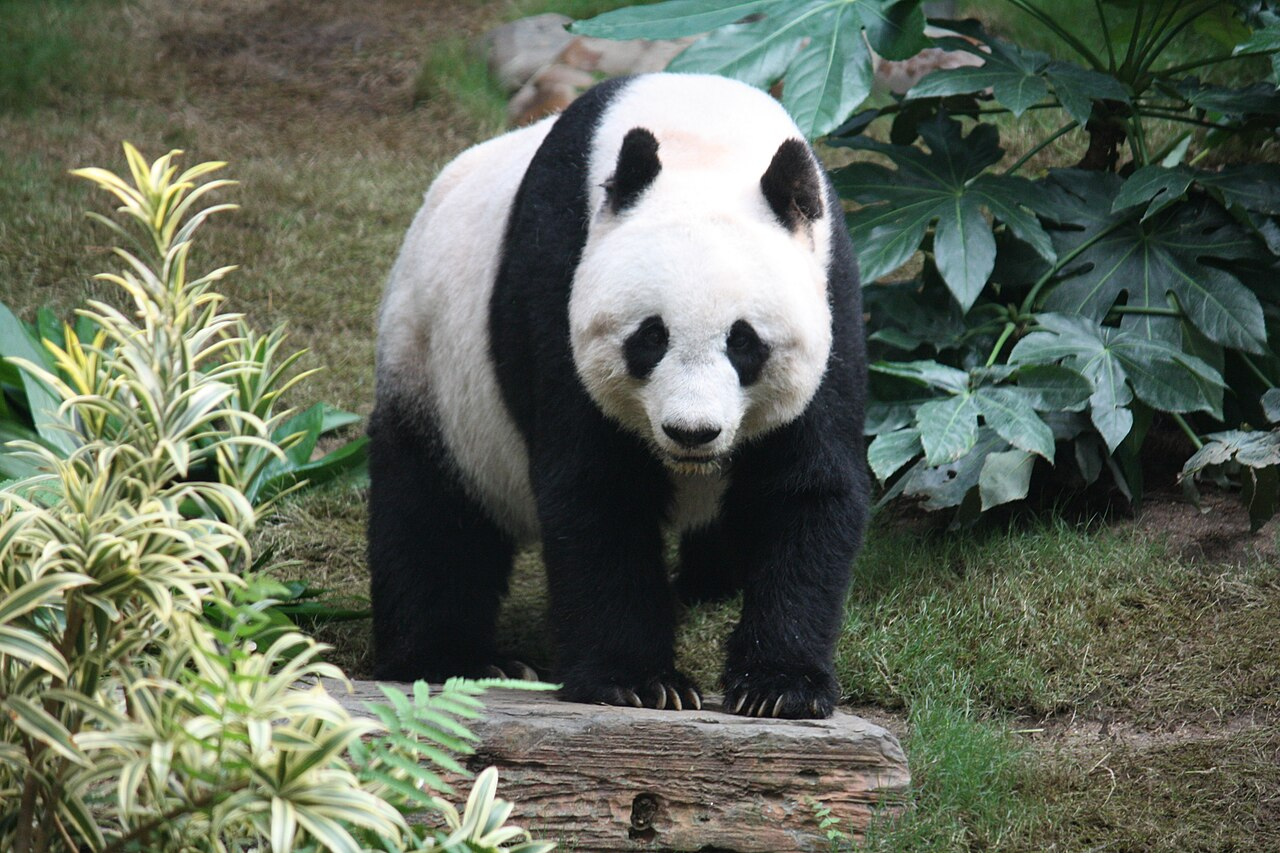

In [4]:
# test viewing image
img = Image.open("data/Grosser_Panda.jpg")
display(img)

In [5]:
# define transform used for ImageNet
transform = transforms.Compose([            #[1]
 transforms.Resize(256),                    #[2]
 transforms.CenterCrop(224),                #[3]
 transforms.ToTensor(),                     #[4]
 transforms.Normalize(                      #[5]
 mean=[0.485, 0.456, 0.406],                #[6]
 std=[0.229, 0.224, 0.225]                  #[7]
 )])

In [6]:
# load classes labels, source https://github.com/anishathalye/imagenet-simple-labels/blob/master/imagenet-simple-labels.json
with open('data/imagenet-simple-labels.json', 'r') as file:
    classes = json.load(file)

In [7]:
# classify image
img_t = transform(img)
batch_t = torch.unsqueeze(img_t, 0)
alexnet.eval()
out = alexnet(batch_t)

In [9]:
# verify that classification works as expected
_, indices = torch.sort(out, descending=True)
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
[(classes[idx], percentage[idx].item()) for idx in indices[0][:5]]

[('giant panda', 99.99685668945312),
 ('black-and-white colobus', 0.0031322292052209377),
 ('American black bear', 5.027247880207142e-06),
 ('indri', 1.8414345959172351e-06),
 ('soccer ball', 1.7047613027898478e-06)]

In [10]:
# check top class
_, index = torch.max(out, 1)
print(classes[index[0]], percentage[index[0]].item())

giant panda 99.99685668945312


In [11]:
# Define function to classify an image and return top class
def classify_image(image, model = alexnet, labels=classes):
    model.eval()
    output=model(image)
    percentage = torch.nn.functional.softmax(output, dim=1)[0] * 100
    _, index = torch.max(output, 1)
    return labels[index[0]], percentage[index[0]].item()

In [12]:
# We use 5 images from wikimedia to test adversarial attack approach
test_set = {'panda':'data/Grosser_Panda.jpg',
            'car':'data/Car.jpg',
            'cat':'data/cat.jpg',
            'waterfall':'data/waterfall.jpg',
            'firetruck':'Data/Logan_Engine_Lamb.jpg'}

In [19]:
# Functions from https://pytorch.org/tutorials/beginner/fgsm_tutorial.html 
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image - epsilon*sign_data_grad # - as targeted
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

# restores the tensors to their original scale
def denorm(batch, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    if isinstance(mean, list):
        mean = torch.tensor(mean)
    if isinstance(std, list):
        std = torch.tensor(std)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

In [20]:
# Define function we can use to test adversarial attack with test set and given class
def test( model,test_set, epsilon, target_class):
    adv_examples = []
    out_classes=[]
    target=torch.tensor([classes.index(target_class)]).type(torch.LongTensor)
    # Loop over all examples in test set
    for t in test_set:
        data = Image.open(test_set[t])
        data_t = torch.unsqueeze(transform(data),0)
        
        # Set requires_grad attribute of tensor. Important for Attack
        data_t.requires_grad = True

        # Forward pass the data through the model
        output = model(data_t)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # Calculate the loss
        loss = nn.CrossEntropyLoss()(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect ``datagrad``
        data_grad = data_t.grad.data

        # Restore the data to its original scale
        data_denorm = denorm(data_t)

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)

        # Reapply normalization
        perturbed_data_normalized = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(perturbed_data)
        # Re-classify the perturbed image
        output = model(perturbed_data)

        adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        adv_examples.append(adv_ex)
        out_classes.append(classify_image(perturbed_data_normalized))

    return adv_examples, out_classes

In [28]:
ex, out = test(alexnet,test_set, 0.1,'jigsaw puzzle')
out

[('jigsaw puzzle', 67.85778045654297),
 ('tow truck', 19.113086700439453),
 ('jigsaw puzzle', 56.83367156982422),
 ('prayer rug', 47.010738372802734),
 ('jigsaw puzzle', 54.04730987548828)]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.846556e-17..1.0].


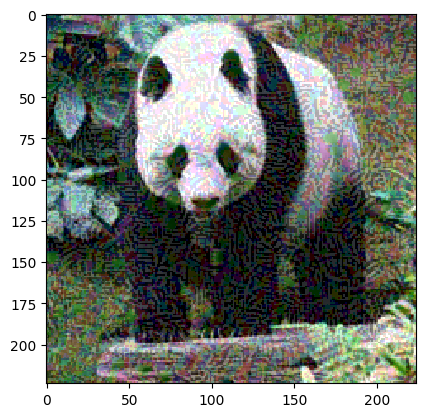

In [29]:
plt.imshow(ndimage.rotate(ex[0].T, 270), interpolation='nearest')

We can see that this added noise to the image and that this has caused the image to incorrectly be labelled as 'jigsaw puzzle' despite the fact that it clearly shows a panda. However we note:
1. The confidence of the classification is fairly low.
2. Only 3/5 of the images have been labelled as 'jigsaw puzzle', although all of them have deviated from their original class.
3. A notable amount of noise is required to lead to relabelling. 
4. 'Jigsaw puzzle' was actually chosen because this is a common misclassification. We can see that if we try another class eg gibbon.

In [31]:
ex, out = test(alexnet,test_set, 0.2,'gibbon')
out

[('jigsaw puzzle', 50.937957763671875),
 ('peacock', 74.1097412109375),
 ('peacock', 70.52172088623047),
 ('peacock', 36.81273651123047),
 ('jigsaw puzzle', 26.237375259399414)]

In order for this to be turned into an actual tool for generating adversarial attacks the following would be needed:
1. Troubleshoot what is going wrong with the above approach. FGSM is a standard approach to this problem, and therefore we would expect to see better performance than we currently see. I am particularly concerned about the transforms used here and believe they need further investigation. We will also need to optimise the parameter epsilon.
2. An alternative approach would be to try a different strategy to FGSM. As outlined in the fascinating chapter https://christophm.github.io/interpretable-ml-book/adversarial.html there are many such approaches, many of which are more advanced than FGSM.
3. It is clear that adversarial attack examples can be cherry picked, but given any image and any label it may be difficult to create a functioning attack. Therefore, any tool developed for this process should include a measure of the degree of success in its output. It may also be useful to develop tools to determine which target classes are most achievable for a given image, allowing the user to choose from a short list.